## OX24006_EMATM0048 Part 2
### Exploratory Analysis of Skincare Subreddits

This exploratory analysis is looking into skincare trends.

The decision to look at skincare was inspired by my own first experience into the feild of digital health. It was a bio-business project, and due to my interest in skincare, our pitch proposed using Artificial Intelligence/Machine Learning to analyse pictures and videos of skin to diagnose conditions and deliver personalised skincare solutions based on scientific papers and online information. This was all theoretical (and business-focused rather than technical) and happened in 2018. At that time, AI was not as accessible as it is today, and to the best of our knowledge, such a feature for skin did not exist (it does now).

Thus, I chose to revisit skincare to see how, or if it has evolved over the last few years, while also satisfying a personal curiosity about how some of the technical aspects of our project might have taken shape.

For this analysis we are scrapping different skincare subreddits and monintoring how they have changed. Reddit was chosen as the platform for webscrapping for the ease of use of its crawler. Being python based, reddit was a good choice to ensure information was scrapped accurately. 

Reddit has various skincare platforms, when searching "Skincare on Reddit" these are the top 3 subreddits: 

1. r/SkincareAddcition with 4.3m members
2. r/AsianBeauty with 2.9m members
3. r/30PlusSkinCare with 2.1m members

Additional, country specific subreddits: 
1. r/SkincareAddictionUK with 484k members
2. r/IndianSkincareAddicts with 242k members
3. r/AusSkincare with 177k members

There are other large subreddits such as:
1. r/Skincare_Addiction with 1.8 members
2. r/SkincareAddicts with 1m members

However, these two subreddits are likely spin-offs of r/SkincareAddition. While the rest of the subreddits target a nicher group (Asian brands, >30, UK, India, Aus), the demographic of these two would be similar to r/SkincareAddiction and thus will not be used. 

### Exploratory Analysis: Question 
This analysis will be based on the question: **How has skincare trends changed over the last few years?** 

Further subquestions based on the data set are:
- Are there differences in skincare trends in different subreddits?
- Do concerns change between different subreddits?

### Step 1: Crawling a real world data set 
#### Step 1.1 Importing necessary functions and setting up PRAW

In [6]:
#import necessary functions (as needed so far)
import datetime 
import praw #reddit crawler
import pandas as pd

#things needed to use PRAW
client_id = '5KkxQHtUgHzvz6pPMTbvSw'
client_secret = 'mWXvZcxvcpyEheEt_gM_3ODTvOBw7g'
user_agent = 'cryinginpython98'

reddit = praw.Reddit(client_id=client_id,client_secret=client_secret,user_agent=user_agent)

#create a list of subreddits 
#create empty list for the posts 
#loop through - take title, body, upvotes, comment, created 

#### Step 1.2 Checking if reddit API Key is working
Output = true if working

In [8]:
print(reddit.read_only) #check if it is working, needs to output == True

True


#### Step 1.3: Selecting Subreddits 
This exploratory analysis will be looking at 6 different skincare subreddits. As mentioned above, a general skincare subreddit (which is also the most popular), as well as more niche subreddits that are targetted at people who like specific brands (Asian Beauty), people from different countries (UK, Aus/NZ, India), or a different age group (>30).

In [10]:
#input all the subreddits we are looking at
subreddit1 = reddit.subreddit('SkincareAddiction')
subreddit2 = reddit.subreddit('AsianBeauty')
subreddit3 = reddit.subreddit('30PlusSkinCare')
subreddit4 = reddit.subreddit('SkincareAddictionUK')
subreddit5 = reddit.subreddit('IndianSkincareAddicts')
subreddit6 = reddit.subreddit('AusSkincare')
#create a list to loop through
subreddits = [subreddit1,subreddit2,subreddit3,subreddit4,subreddit5,subreddit6]

#Displaying the subreddits, also as a check to see if the subreddits are being called correctly
for subreddit in subreddits:
    # Display the name of the Subreddit
    print("Display Name:", subreddit.display_name)
    # Display the title of the Subreddit
    print("Title:", subreddit.title)

Display Name: SkincareAddiction
Title: For anything and everything having to do with skincare!
Display Name: AsianBeauty
Title: AsianBeauty
Display Name: 30PlusSkinCare
Title: Skin care for people over 30
Display Name: SkincareAddictionUK
Title: A UK-centric skincare subreddit.
Display Name: IndianSkincareAddicts
Title: IndianSkincareAddicts
Display Name: AusSkincare
Title: Australian & New Zealand Skincare


#### Step 1.4 Loading of Subreddit Data into DataFrame
Inital runs of this exploratory analysis only looked into the top posts, however, due to the casual nature of these forums, there are many joke (meme) posts. This was not as condusive to looking into the skincare side of the skincare subreddit. Hence, the search will be targeting specific ingridents and skin concerns. Popular or trending skincare ingridents are identified with the a google, and a couple ingridents manually added based on own knowledge. Similarly, common skin concerns are identified with google.

#### Step 1.5 Defining Skin Concerns and Ingredients

In [170]:
#Ingredients that will be searched for
ing = [
    'retinol', 'vitamin c', 'hyaluronic', 'niacinamide', 'salicylic',
    'benzoyl peroxide', 'glycerin', 'peptide', 'ceramide',
    'bakuchiol', 'vitamin e', 'glycolic', 'spf', 
    'squalene', 'jojoba', 'azelaic', 'hydroquinone', 'lactic'
]
#concerns to be looked at
concerns = [
    'acne', 'dry', 'dull', 'redness', 'dark circles', 'eye bags', 
    'wrinkle', 'aging', 'uneven', 'rough', 'hyperpigmentation', 'sunscreen' #sunscreen as a proxy for sun damage/sun protection
]

In [172]:
def get_date(submission):
    '''Function to convert the timestamp from html to useable time'''
    time = submission.created
    return datetime.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')

In [176]:
#initialize list that will hold all the data scrapped
info = []

#### Step 1.6 Looping through the subreddits to extract the relevant data

Looping to go through the Top 1000 posts in each subreddit. It will see if the ingredients/concern is present and add it into the dataset. The dataset will then be saved into a pandas dataframe

In [178]:
#loop through each of the subreddits
for subreddit in subreddits:
    #loop through the top 1000 posts
    for sub in subreddit.top(limit=1000):
        #lowercase for search
        title = sub.title.lower()  
        body = sub.selftext.lower()

        #default 
        ing_pres = None
        concern_pres = None 

        #loop for each ingredient in the ing list
        for ingredient in ing:
            #if exists in the posts title or body
            if ingredient in title or ingredient in body:
                #ingredient present, assign value
                ing_pres = ingredient
    
        #loop for each concern in concern list
        for concern in concerns:
            #if exists in posts title or body
            if concern in title or concern in body:
                concern_pres = concern

        #call function to change the date to something useable
        sub_date = get_date(sub)

        #now the main thing,
        #if the post contains a mention of what we want (ingredient or concern)
        #add it to the dictionary
        if ing_pres or concern_pres:
                sub_data = {
                    'subreddit': subreddit.display_name,
                    'title': sub.title,
                    'body': sub.selftext,
                    'upvotes': sub.score,
                    'num_comments': sub.num_comments,
                    'url': sub.url,
                    'ingredient' : ing_pres,
                    'concern': concern_pres,
                    'date': sub_date
                }
                #append to list
                info.append(sub_data)

print(len(info)) #see what data collected 

2201


In [181]:
#create pandas dataframe
df=pd.DataFrame(info)
#see whats inside
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     2201 non-null   object
 1   title         2201 non-null   object
 2   body          2201 non-null   object
 3   upvotes       2201 non-null   int64 
 4   num_comments  2201 non-null   int64 
 5   url           2201 non-null   object
 6   ingredient    987 non-null    object
 7   concern       1848 non-null   object
 8   date          2201 non-null   object
dtypes: int64(2), object(7)
memory usage: 154.9+ KB


In [183]:
df.head(10) #see whats inside

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
0,SkincareAddiction,Posted here over a month ago showing how [acne...,,17346,257,https://i.redd.it/dtm3c3p277z41.jpg,None,acne,2020-05-16 22:50:03
1,SkincareAddiction,[Anti-Aging] I may have used too much retinol ...,,15810,115,https://i.redd.it/r8g7c71mti3a1.jpg,retinol,sunscreen,2022-12-02 17:36:48
2,SkincareAddiction,[Selfie] 2 year transformation and glow up. Cy...,,11637,287,https://i.redd.it/8l4z6jzyogb51.jpg,None,acne,2020-07-17 19:36:02
3,SkincareAddiction,[Personal] My Mother at 53 years old. She's th...,,11228,272,http://i.imgur.com/Ph4JiDD.jpg,None,sunscreen,2016-10-16 22:19:03
4,SkincareAddiction,"[B&A] [Selfie] 3 microneedling sessions, 1 las...",,11144,340,https://i.redd.it/ruermpk6cwg31.jpg,hyaluronic,None,2019-08-17 00:35:56
5,SkincareAddiction,[Before&After] Finding the right dermatologist...,,11139,484,https://www.reddit.com/gallery/nn7th5,spf,sunscreen,2021-05-28 22:13:12
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,https://www.reddit.com/r/SkincareAddiction/com...,None,sunscreen,2020-06-02 18:15:31
7,SkincareAddiction,Puberty is making [Acne] hit hard but we’re tr...,,10508,435,https://i.redd.it/o74bastn0iq41.jpg,None,rough,2020-04-03 01:36:29
8,SkincareAddiction,[Humor] SPF > all other skincare,,10384,416,https://i.redd.it/lrccxnwvnm851.jpg,spf,None,2020-07-03 12:28:12
9,SkincareAddiction,[B&A] I posted my acne scar treatment progress...,,10304,350,https://i.redd.it/g7dlglcqhn011.jpg,None,acne,2018-05-28 20:47:06


In [185]:
df.tail(10) #see whats inside from behind

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
2191,AusSkincare,I need help with blackheads,I'm currently using the hydro boost as my clea...,40,44,https://i.redd.it/0z85d7qo9jv91.jpg,None,rough,2022-10-23 06:33:45
2192,AusSkincare,Meccas Sunscreen serum ☀️,Has anyone tried this yet? It looks so interes...,44,9,https://i.redd.it/yp6u27kfaqj91.jpg,None,sunscreen,2022-08-24 22:20:46
2193,AusSkincare,We can now drop off all brands of empty beauty...,,42,2,https://i.redd.it/wfnxr6c4tdg91.png,None,aging,2022-08-08 01:11:11
2194,AusSkincare,Your favourite SPF50+ long lasting sunscreen,I’ve just got a job as a Traffic Controller wh...,41,21,https://www.reddit.com/r/AusSkincare/comments/...,spf,sunscreen,2021-11-30 09:30:33
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,https://www.reddit.com/r/AusSkincare/comments/...,vitamin c,rough,2021-09-08 10:29:31
2196,AusSkincare,Hey what’s everyone’s experience with these tw...,,40,72,https://www.reddit.com/gallery/jsqrds,None,sunscreen,2020-11-12 07:54:16
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,https://www.reddit.com/r/AusSkincare/comments/...,jojoba,None,2020-08-11 10:48:35
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,https://www.reddit.com/r/AusSkincare/comments/...,spf,None,2020-07-28 02:53:20
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,https://www.reddit.com/r/AusSkincare/comments/...,bakuchiol,None,2020-06-21 04:42:50
2200,AusSkincare,Best Of/ Holy Grail Products: EXFOLIANTS,Hi there and welcome to the Best Of/ Holy Grai...,43,19,https://www.reddit.com/r/AusSkincare/comments/...,None,rough,2019-10-15 01:02:53


#### Step 1.7 Export into CSV

In [190]:
df.to_csv('OX24006_SDPA_data.csv') #export to csv

#### 1.8 Describing this data set: 

This data set comes from 6 different skincare subreddits. The most popular skincare subreddit, 2 of the next most popular skincare subreddits that are targetted at a more niche audience (Asian Beauty and Skincare over 30), as well as 3 more niche subreddits which are still in the top few but relatively not as popular. 

Data was scrapped using PRAW, Python Reddit API Wrapper. The top posts were scrapped and added into the data set if they referenced ingredients or concerns of interest. 

The initial list of variables for consideration were based off PRAW guides: Title, Body (Self-text), URL, upvotes and comments, after some iterations of the analysis. Two other variables : ingredients and concerns were also searched for and added.  Most of the data here is categorical, with comments and upvotes being numerical. 

### Step 2: Data Preparation and Cleaning 
The next step in this analysis would be to clean and prepare the data.

In [194]:
#So a proper copy is needed, if not any changes made to a "copy" will mess up the analysis 
wdf = df.copy() #working df

#### Step 2.1 Handling duplicates

Using drop duplicates to remove any duplicate values.

In [196]:
wdf.drop_duplicates() #remove doops

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
0,SkincareAddiction,Posted here over a month ago showing how [acne...,,17346,257,https://i.redd.it/dtm3c3p277z41.jpg,None,acne,2020-05-16 22:50:03
1,SkincareAddiction,[Anti-Aging] I may have used too much retinol ...,,15810,115,https://i.redd.it/r8g7c71mti3a1.jpg,retinol,sunscreen,2022-12-02 17:36:48
2,SkincareAddiction,[Selfie] 2 year transformation and glow up. Cy...,,11637,287,https://i.redd.it/8l4z6jzyogb51.jpg,None,acne,2020-07-17 19:36:02
3,SkincareAddiction,[Personal] My Mother at 53 years old. She's th...,,11228,272,http://i.imgur.com/Ph4JiDD.jpg,None,sunscreen,2016-10-16 22:19:03
4,SkincareAddiction,"[B&A] [Selfie] 3 microneedling sessions, 1 las...",,11144,340,https://i.redd.it/ruermpk6cwg31.jpg,hyaluronic,None,2019-08-17 00:35:56
...,...,...,...,...,...,...,...,...,...
2196,AusSkincare,Hey what’s everyone’s experience with these tw...,,40,72,https://www.reddit.com/gallery/jsqrds,None,sunscreen,2020-11-12 07:54:16
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,https://www.reddit.com/r/AusSkincare/comments/...,jojoba,None,2020-08-11 10:48:35
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,https://www.reddit.com/r/AusSkincare/comments/...,spf,None,2020-07-28 02:53:20
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,https://www.reddit.com/r/AusSkincare/comments/...,bakuchiol,None,2020-06-21 04:42:50


Return value shows no duplicates in dataset

#### Step 2.2 Handling missing data
 
From glancing at the dataset, there are many instances of missing body in a reddit submission. These will need to be deleted. 

In addition, there are two instances of values that are missing on purpose. The scraping rules set wanted to find posts related to either specific skincare ingredients or specific skin care concerns. Not all posts would have both. 

Before removal of rows with missing values, the necessary null values will be filled. 

In addition, I want to also observe the dataset that has both ingredient and concern. Hence, another copy will be made, and all none values will be removed.

In [200]:
#Creating a second copy, this will have both concerns and ingredients.
df_both = df.copy() #create copy

In [202]:
df_both.dropna() #drop rows with anything empty 

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
1,SkincareAddiction,[Anti-Aging] I may have used too much retinol ...,,15810,115,https://i.redd.it/r8g7c71mti3a1.jpg,retinol,sunscreen,2022-12-02 17:36:48
5,SkincareAddiction,[Before&After] Finding the right dermatologist...,,11139,484,https://www.reddit.com/gallery/nn7th5,spf,sunscreen,2021-05-28 22:13:12
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,https://www.reddit.com/r/SkincareAddiction/com...,retinol,aging,2022-06-16 15:25:32
44,SkincareAddiction,[PSA] If someone is happy with their skincare ...,I think many of us have been in this situation...,6435,482,https://www.reddit.com/r/SkincareAddiction/com...,hyaluronic,sunscreen,2019-10-02 00:39:13
61,SkincareAddiction,[B&A] A lurkers 14-15 months of hard work and ...,"As an avid lurker, I have finally decided to p...",5670,241,https://www.reddit.com/gallery/z4wy65,glycolic,sunscreen,2022-11-26 03:36:58
...,...,...,...,...,...,...,...,...,...
2187,AusSkincare,Where are you buying products from? How much a...,I saw a dermal clinician at a skincare place a...,43,81,https://www.reddit.com/r/AusSkincare/comments/...,spf,redness,2024-11-04 02:27:14
2188,AusSkincare,After years of struggle I’ve found the answer ...,So after years of fighting with sunscreen and ...,42,18,https://www.reddit.com/r/AusSkincare/comments/...,spf,sunscreen,2024-09-03 21:41:54
2189,AusSkincare,Priceline’s free skincare gift bag promotion s...,What I purchased to get the gift bag: \n\nCer...,43,28,https://i.redd.it/9tndg6xsyu1c1.jpg,spf,hyperpigmentation,2023-11-22 08:16:33
2194,AusSkincare,Your favourite SPF50+ long lasting sunscreen,I’ve just got a job as a Traffic Controller wh...,41,21,https://www.reddit.com/r/AusSkincare/comments/...,spf,sunscreen,2021-11-30 09:30:33


The current row count is currently 634. However the preview shows that there is still empty cells in 'body'. In addition, the 'info' portion shows no null values. This indicates that the value in body could possibly be an empty string. 

Thus, replace empty string and remove null values again.

In [205]:
#replace "_" with NA, null value
df_both.replace("", pd.NA, inplace=True)
#remove empty
df_both.dropna(inplace=True)
df_both #print to check

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,https://www.reddit.com/r/SkincareAddiction/com...,retinol,aging,2022-06-16 15:25:32
44,SkincareAddiction,[PSA] If someone is happy with their skincare ...,I think many of us have been in this situation...,6435,482,https://www.reddit.com/r/SkincareAddiction/com...,hyaluronic,sunscreen,2019-10-02 00:39:13
61,SkincareAddiction,[B&A] A lurkers 14-15 months of hard work and ...,"As an avid lurker, I have finally decided to p...",5670,241,https://www.reddit.com/gallery/z4wy65,glycolic,sunscreen,2022-11-26 03:36:58
64,SkincareAddiction,[misc] This is not a “Korean sunscreen” proble...,[The news broke 5 days ago](https://i.stuff.co...,5560,1269,https://www.reddit.com/r/SkincareAddiction/com...,spf,sunscreen,2021-04-13 07:47:52
71,SkincareAddiction,[Personal] Maybe We All Need To Take A Step Ba...,EDIT: thanks for the gold! And for letting me ...,5353,423,https://www.reddit.com/r/SkincareAddiction/com...,spf,wrinkle,2019-07-11 15:01:33
...,...,...,...,...,...,...,...,...,...
2187,AusSkincare,Where are you buying products from? How much a...,I saw a dermal clinician at a skincare place a...,43,81,https://www.reddit.com/r/AusSkincare/comments/...,spf,redness,2024-11-04 02:27:14
2188,AusSkincare,After years of struggle I’ve found the answer ...,So after years of fighting with sunscreen and ...,42,18,https://www.reddit.com/r/AusSkincare/comments/...,spf,sunscreen,2024-09-03 21:41:54
2189,AusSkincare,Priceline’s free skincare gift bag promotion s...,What I purchased to get the gift bag: \n\nCer...,43,28,https://i.redd.it/9tndg6xsyu1c1.jpg,spf,hyperpigmentation,2023-11-22 08:16:33
2194,AusSkincare,Your favourite SPF50+ long lasting sunscreen,I’ve just got a job as a Traffic Controller wh...,41,21,https://www.reddit.com/r/AusSkincare/comments/...,spf,sunscreen,2021-11-30 09:30:33


New value of 596 in df_both

##### Timestamp conversion
Additionally, the date column is written as: "2019-10-15 01:02:53" For analysis of the timeline, we will just look at the year. To do this we need to extract the year and store it into a new column.

Although the  extraction of the timestamp was already done using the datetime function, it did not work without converting the column into a date-time format. Hence the date column was converted into date time before extracting the year. 

In [208]:
#conversion into dt format to use dt function to easily extract year
#select column date, convert to dt
df_both['date'] = pd.to_datetime(df_both['date'])
#new column 'year' with the value of 'date' columns year
df_both['year'] = df_both['date'].dt.year

In [210]:
df_both.info() #check info 

<class 'pandas.core.frame.DataFrame'>
Index: 596 entries, 28 to 2195
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   subreddit     596 non-null    object        
 1   title         596 non-null    object        
 2   body          596 non-null    object        
 3   upvotes       596 non-null    int64         
 4   num_comments  596 non-null    int64         
 5   url           596 non-null    object        
 6   ingredient    596 non-null    object        
 7   concern       596 non-null    object        
 8   date          596 non-null    datetime64[ns]
 9   year          596 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(6)
memory usage: 48.9+ KB


There are now two columns with information unecessary. 
1. URL - this was used for own checking after extraction into csv.
2. Date - with year extracted it is not needed 

In [212]:
df_both = df_both.drop(columns=['url', 'date']) #remove unecessary
df_both

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022
44,SkincareAddiction,[PSA] If someone is happy with their skincare ...,I think many of us have been in this situation...,6435,482,hyaluronic,sunscreen,2019
61,SkincareAddiction,[B&A] A lurkers 14-15 months of hard work and ...,"As an avid lurker, I have finally decided to p...",5670,241,glycolic,sunscreen,2022
64,SkincareAddiction,[misc] This is not a “Korean sunscreen” proble...,[The news broke 5 days ago](https://i.stuff.co...,5560,1269,spf,sunscreen,2021
71,SkincareAddiction,[Personal] Maybe We All Need To Take A Step Ba...,EDIT: thanks for the gold! And for letting me ...,5353,423,spf,wrinkle,2019
...,...,...,...,...,...,...,...,...
2187,AusSkincare,Where are you buying products from? How much a...,I saw a dermal clinician at a skincare place a...,43,81,spf,redness,2024
2188,AusSkincare,After years of struggle I’ve found the answer ...,So after years of fighting with sunscreen and ...,42,18,spf,sunscreen,2024
2189,AusSkincare,Priceline’s free skincare gift bag promotion s...,What I purchased to get the gift bag: \n\nCer...,43,28,spf,hyperpigmentation,2023
2194,AusSkincare,Your favourite SPF50+ long lasting sunscreen,I’ve just got a job as a Traffic Controller wh...,41,21,spf,sunscreen,2021


##### df_both is now a table of cleaned data which has items which mention both a skincare and a concern

#### Same steps will be repeated for the main DF, wdf

In [216]:
#replcace the 'none' with 'not specified'
wdf['ingredient'].fillna('not specificed', inplace=True)
wdf['concern'].fillna('not specified', inplace=True)
wdf #print to check

/var/folders/8j/mb2drjzj3n33v47t1853n8f40000gn/T/ipykernel_3811/1808966493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wdf['ingredient'].fillna('not specificed', inplace=True)
/var/folders/8j/mb2drjzj3n33v47t1853n8f40000gn/T/ipykernel_3811/1808966493.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
0,SkincareAddiction,Posted here over a month ago showing how [acne...,,17346,257,https://i.redd.it/dtm3c3p277z41.jpg,not specificed,acne,2020-05-16 22:50:03
1,SkincareAddiction,[Anti-Aging] I may have used too much retinol ...,,15810,115,https://i.redd.it/r8g7c71mti3a1.jpg,retinol,sunscreen,2022-12-02 17:36:48
2,SkincareAddiction,[Selfie] 2 year transformation and glow up. Cy...,,11637,287,https://i.redd.it/8l4z6jzyogb51.jpg,not specificed,acne,2020-07-17 19:36:02
3,SkincareAddiction,[Personal] My Mother at 53 years old. She's th...,,11228,272,http://i.imgur.com/Ph4JiDD.jpg,not specificed,sunscreen,2016-10-16 22:19:03
4,SkincareAddiction,"[B&A] [Selfie] 3 microneedling sessions, 1 las...",,11144,340,https://i.redd.it/ruermpk6cwg31.jpg,hyaluronic,not specified,2019-08-17 00:35:56
...,...,...,...,...,...,...,...,...,...
2196,AusSkincare,Hey what’s everyone’s experience with these tw...,,40,72,https://www.reddit.com/gallery/jsqrds,not specificed,sunscreen,2020-11-12 07:54:16
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,https://www.reddit.com/r/AusSkincare/comments/...,jojoba,not specified,2020-08-11 10:48:35
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,https://www.reddit.com/r/AusSkincare/comments/...,spf,not specified,2020-07-28 02:53:20
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,https://www.reddit.com/r/AusSkincare/comments/...,bakuchiol,not specified,2020-06-21 04:42:50


After replacement of the empty values, replace the empty strings and drop rows with empty cells

In [218]:
wdf.replace("", pd.NA, inplace=True)
#remove empty
wdf.dropna(inplace=True)
wdf

,subreddit,title,body,upvotes,num_comments,url,ingredient,concern,date
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,https://www.reddit.com/r/SkincareAddiction/com...,not specificed,sunscreen,2020-06-02 18:15:31
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,https://www.reddit.com/r/SkincareAddiction/com...,retinol,aging,2022-06-16 15:25:32
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,https://www.reddit.com/r/SkincareAddiction/com...,not specificed,acne,2019-04-01 19:32:52
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,https://www.reddit.com/r/SkincareAddiction/com...,not specificed,acne,2019-11-13 20:48:40
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,https://i.redd.it/exq7gqm3627b1.jpg,not specificed,redness,2023-06-20 00:21:45
...,...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,https://www.reddit.com/r/AusSkincare/comments/...,vitamin c,rough,2021-09-08 10:29:31
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,https://www.reddit.com/r/AusSkincare/comments/...,jojoba,not specified,2020-08-11 10:48:35
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,https://www.reddit.com/r/AusSkincare/comments/...,spf,not specified,2020-07-28 02:53:20
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,https://www.reddit.com/r/AusSkincare/comments/...,bakuchiol,not specified,2020-06-21 04:42:50


Extraction of year:

In [220]:
#conversion into dt format to use dt function to easily extract year
#select column date, convert to dt
wdf['date'] = pd.to_datetime(wdf['date'])
#new column 'year' with the value of 'date' columns year
wdf['year'] = wdf['date'].dt.year

As in df_both, the unecessary columns are removed

In [222]:
wdf = wdf.drop(columns=['url', 'date'])
wdf

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,not specificed,sunscreen,2020
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,not specificed,acne,2019
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,not specificed,acne,2019
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,not specificed,redness,2023
...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,vitamin c,rough,2021
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,jojoba,not specified,2020
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,spf,not specified,2020
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,bakuchiol,not specified,2020


##### Normalizing the upvotes and comments:
Just from looking at the DataFrame, it is clear that there is a huge difference between comment and upvotes in the different subreddits. This is likely due to the differences in member number:
- r/SkincareAddcition - 4.3m members
- r/AsianBeauty - 2.9m members
- r/30PlusSkinCare - 2.1m members
- r/SkincareAddictionUK - 484k members
- r/IndianSkincareAddicts - 242k members
- r/AusSkincare with - members


Normalization will be done by making it a ratio of the subreddit's member count. 
- upvotes_norm = upvotes/members * 100000
- comments_norm = comments/members * 100000

100000 value was decided by trial and error, starting at 1000, to find at which point the normalized number would be best viewed

In [224]:
#because not in DF, need to add in
#create dict with numbers
subreddit_members = {
    'SkincareAddiction': 4300000,  
    'AsianBeauty': 2900000,
    '30PlusSkinCare': 2100000,
    'SkincareAddictionUK': 484000,
    'IndianSkincareAddicts': 242000,
    'AusSkincare': 177000
}

#use map function to add 
wdf['members'] = wdf['subreddit'].map(subreddit_members)

#def function to normalize the variables
def normalization(row, column):
    """basically a function to just divide it by the member count, and mulitply by 100000"""
    return (row[column] / row['members'])*100000
    
wdf['upvotes_norm'] = wdf.apply(normalization, axis=1, column='upvotes') #apply function
wdf['comments_norm'] = wdf.apply(normalization, axis=1, column='num_comments') #apply function
wdf

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year,members,upvotes_norm,comments_norm
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,not specificed,sunscreen,2020,4300000,252.651163,7.744186
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022,4300000,174.279070,10.116279
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,not specificed,acne,2019,4300000,173.651163,6.837209
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,not specificed,acne,2019,4300000,168.558140,8.162791
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,not specificed,redness,2023,4300000,166.279070,5.441860
...,...,...,...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,vitamin c,rough,2021,177000,23.728814,8.474576
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,jojoba,not specified,2020,177000,24.293785,32.203390
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,spf,not specified,2020,177000,23.163842,18.644068
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,bakuchiol,not specified,2020,177000,25.423729,11.864407


Additionally, a ratio value for the relationship between the upvotes and the comments will be calculated to determine the post engagement. 
- comments/upvotes, a number closer to 1 means more engagement 

In [226]:
wdf['engagement'] = wdf['num_comments']/wdf['upvotes'] #calculate the ratio and add new column
wdf

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year,members,upvotes_norm,comments_norm,engagement
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,not specificed,sunscreen,2020,4300000,252.651163,7.744186,0.030652
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022,4300000,174.279070,10.116279,0.058046
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,not specificed,acne,2019,4300000,173.651163,6.837209,0.039373
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,not specificed,acne,2019,4300000,168.558140,8.162791,0.048427
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,not specificed,redness,2023,4300000,166.279070,5.441860,0.032727
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,vitamin c,rough,2021,177000,23.728814,8.474576,0.357143
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,jojoba,not specified,2020,177000,24.293785,32.203390,1.325581
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,spf,not specified,2020,177000,23.163842,18.644068,0.804878
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,bakuchiol,not specified,2020,177000,25.423729,11.864407,0.466667


##### wdf is now a table of cleaned data which has items which mention either a skincare and a concern

##### The same functions have been applied into df_both

In [228]:
df_both['members'] = df_both['subreddit'].map(subreddit_members)
    
df_both['upvotes_norm'] = df_both.apply(normalization, axis=1, column='upvotes') #apply function
df_both['comments_norm'] = df_both.apply(normalization, axis=1, column='num_comments') #apply function
df_both['engagement'] = df_both['num_comments']/df_both['upvotes']
df_both

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year,members,upvotes_norm,comments_norm,engagement
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022,4300000,174.279070,10.116279,0.058046
44,SkincareAddiction,[PSA] If someone is happy with their skincare ...,I think many of us have been in this situation...,6435,482,hyaluronic,sunscreen,2019,4300000,149.651163,11.209302,0.074903
61,SkincareAddiction,[B&A] A lurkers 14-15 months of hard work and ...,"As an avid lurker, I have finally decided to p...",5670,241,glycolic,sunscreen,2022,4300000,131.860465,5.604651,0.042504
64,SkincareAddiction,[misc] This is not a “Korean sunscreen” proble...,[The news broke 5 days ago](https://i.stuff.co...,5560,1269,spf,sunscreen,2021,4300000,129.302326,29.511628,0.228237
71,SkincareAddiction,[Personal] Maybe We All Need To Take A Step Ba...,EDIT: thanks for the gold! And for letting me ...,5353,423,spf,wrinkle,2019,4300000,124.488372,9.837209,0.079021
...,...,...,...,...,...,...,...,...,...,...,...,...
2187,AusSkincare,Where are you buying products from? How much a...,I saw a dermal clinician at a skincare place a...,43,81,spf,redness,2024,177000,24.293785,45.762712,1.883721
2188,AusSkincare,After years of struggle I’ve found the answer ...,So after years of fighting with sunscreen and ...,42,18,spf,sunscreen,2024,177000,23.728814,10.169492,0.428571
2189,AusSkincare,Priceline’s free skincare gift bag promotion s...,What I purchased to get the gift bag: \n\nCer...,43,28,spf,hyperpigmentation,2023,177000,24.293785,15.819209,0.651163
2194,AusSkincare,Your favourite SPF50+ long lasting sunscreen,I’ve just got a job as a Traffic Controller wh...,41,21,spf,sunscreen,2021,177000,23.163842,11.864407,0.512195


### Step 3 Exploratory analysis

In [230]:
#importing seaborn and matplotlib for data visualization
import numpy as np
import colorcet as cc
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

#### 3.1 Counts of each item

##### 3.1.1 Number of submissions per subreddit

Using value counts to show the number of posts extracted from each subreddit.

In [234]:
counts_subreddit= wdf['subreddit'].value_counts()
print(counts_subreddit)

subreddit
SkincareAddictionUK      573
30PlusSkinCare           343
IndianSkincareAddicts    341
AusSkincare              240
AsianBeauty              111
SkincareAddiction         67
Name: count, dtype: int64


Now displaying it as a pie chart

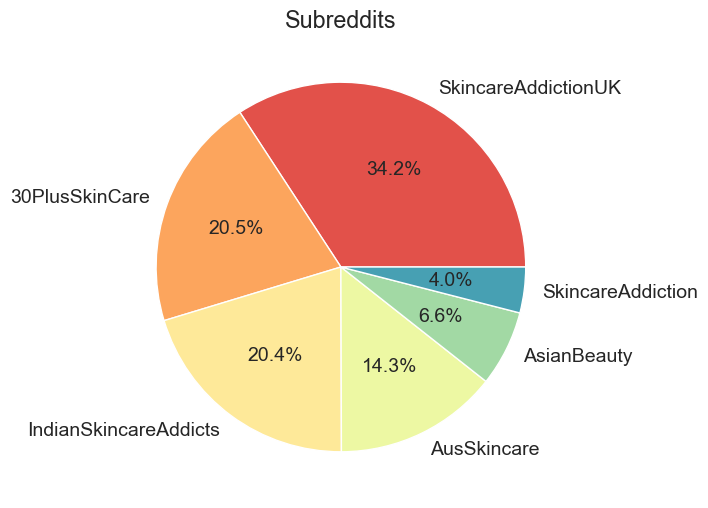

In [238]:
pie_colour = sns.color_palette("Spectral", 6)
plt.figure(figsize=(6,6))
plt.pie(counts_subreddit.values, labels=counts_subreddit.index, autopct='%1.1f%%',colors=pie_colour)
plt.title('Subreddits')
plt.savefig('pie_subreddits.png') 
plt.show()

Despite SkincareAddition and Asian beauty being the largest two subreddits, these two subreddits brought in the fewest number of submissions that bring up the specific skincare concerns or ingredients. It is possible that due to the large size of the subreddit, more of the top posts did not fit our search criteria. For AsianBeauty, this subreddit includes makeup as well as skincare, which could contribute to it being the second lowest. 

This could indicate that despite their large size, r/SkincareAdditction and r/AsianBeauty may not be the top choice for someone wanting information on skincare. It is possible that smaller subredits could be more useful in finding information and that the members are more likely to help with a specific skincare-related question. Further analysis into this will be done using engagement ratio.

##### 3.1.2 Number of each ingredient and concern mentioned

Counts for each will be displayed and a bar plot to visualize the data

In [241]:
counts_ing= wdf['ingredient'].value_counts()
counts_concern = wdf['concern'].value_counts()
print(counts_ing)
print(counts_concern)

ingredient
not specificed      834
spf                 302
glycolic             64
lactic               62
azelaic              59
niacinamide          42
vitamin c            42
hyaluronic           38
retinol              38
salicylic            35
ceramide             34
peptide              26
benzoyl peroxide     18
vitamin e            18
hydroquinone         17
glycerin             15
jojoba               14
squalene             11
bakuchiol             6
Name: count, dtype: int64
concern
sunscreen            533
rough                276
not specified        245
aging                156
dry                  139
acne                 133
redness               56
hyperpigmentation     51
wrinkle               47
dark circles          15
uneven                12
dull                   9
eye bags               3
Name: count, dtype: int64


##### The count information will be displayed as a bar plot: 

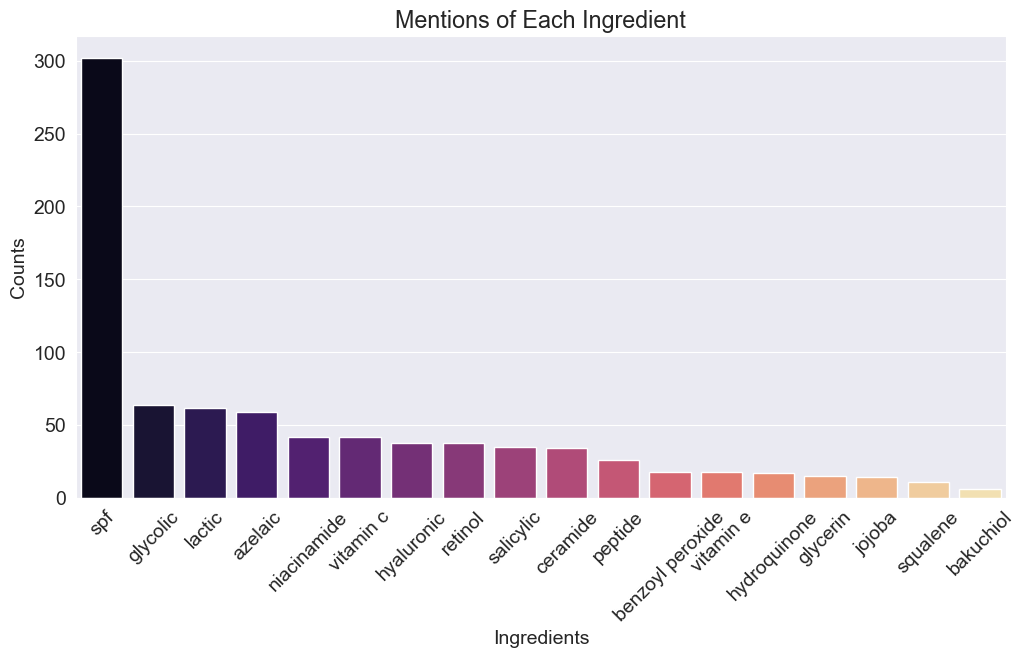

In [245]:
count_ing = counts_ing.drop('not specificed') #made a spelling error here now live with it
colour = sns.color_palette("magma",18)
plt.figure(figsize=(12, 6))
sns.barplot(x=count_ing.index, y=count_ing.values,palette=colour,hue=count_ing.index,dodge=False,legend=False) 

# Customize the plot
plt.xticks(rotation=45)
plt.title('Mentions of Each Ingredient')
plt.xlabel('Ingredients')
plt.ylabel('Counts')
plt.savefig('count_ing.png') 
plt.show()


SPF was the most mentioned ingredient by a significant margin. This would also alight with sunscreen being the most talked about concern. 
Following this, glycolic (acid) was the most mentioned term, followed by latic (acid) and azelaic (acid). These three are considered exfoliants, it would then be expected that concern about acne or skin texture would be prominent skin issues. The next most popular is niacinamide, and all round ingridient. Vitamin c, which is brightening. Hyaluronic (acid), which is hydrating. Followed by ceramides, for skin barrier and retinol, for skin renewal. 

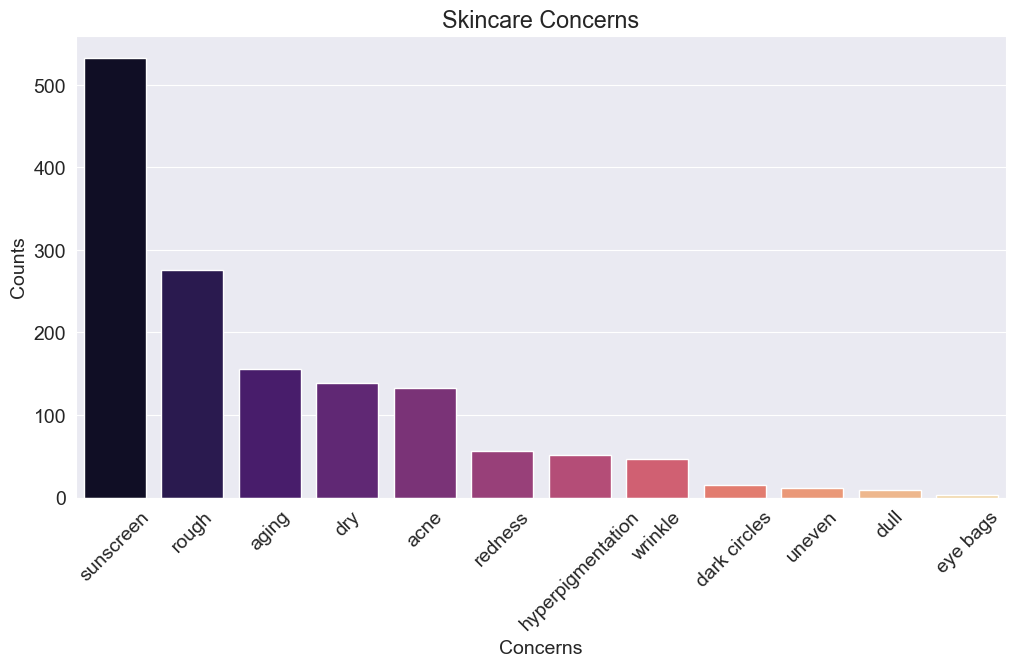

In [248]:
count_concern = counts_concern.drop('not specified')
colour = sns.color_palette("magma",12)
plt.figure(figsize=(12, 6))
sns.barplot(x=count_concern.index, y=count_concern.values,palette=colour,hue=count_concern.index,dodge=False,legend=False) 

# Customize the plot
plt.xticks(rotation=45)
plt.title('Skincare Concerns')
plt.xlabel('Concerns')
plt.ylabel('Counts')
plt.savefig('count_concern.png') 
plt.show()

The bar plot shows us that sunscreen was most talked about by a stagering amount. While the term 'sunscreen' itself is not directly a skin concern, but it insinuates desire for skin protection. Sunscreen is widely considered the most important skincare item. As such it make sense that it is the most prominent item being brought up in the skincare subreddit. The most talked about skincare ingredient was also spf, corroborating the poopularity and importance of sun protection for skincare-lovers.

The second most common concern on reddit was 'rough' suggesting problems with skin texture. This is in line with the ppopular ingredients bring exfoliants. The next concern was aging, which is expected considered the nature of the topic. Dry and acne are abour equal in terms of mentions. 

It should also be noted that one post may not only be mentioning one ingredient or concern, but only the first is picked up.

#### Step 3.3 Mean, sum, range 
Only 3 values are numerical in this data set: upvotes and comments (as well as their normalzied versions) and engagement. Year is sorted as an integer but is more categorical in this case. However, the finding the range helps us to see the breath of our data set. 

In [251]:
wdf.describe()

,upvotes,num_comments,year,members,upvotes_norm,comments_norm,engagement
count,1675.000000,1675.000000,1675.000000,1.675000e+03,1675.000000,1675.000000,1675.000000
mean,621.467463,120.491940,2021.601194,1.034408e+06,49.276791,17.372959,0.563060
std,1516.870971,172.463894,2.080747,1.107819e+06,68.525064,22.920898,0.612845
min,17.000000,0.000000,2014.000000,1.770000e+05,3.512397,0.000000,0.000000
25%,41.000000,24.000000,2020.000000,2.420000e+05,8.574380,4.317829,0.177995
50%,134.000000,57.000000,2022.000000,4.840000e+05,32.761905,9.428571,0.363636
75%,584.000000,139.500000,2023.000000,2.100000e+06,63.223140,22.033898,0.697729
max,27307.000000,1638.000000,2024.000000,4.300000e+06,1300.333333,365.289256,6.960630


From the table above, we see that the earliest year of posts is 2014, and the latest is 2024. This gives us 10 years of reddit data. 

Looking at the normalzied upvotes and comments, there is still a large range and standard deviation. This makes sense given that top 1000 is a large range. However, the average post engagement is 0.56, with a standard deviation of 0.61, where the range goes from 0 - 6.96. This shows that even a top post could have very little comments and engagement, but alot of people 'liking' the post. 

Using the normalized values for comments, upvotes and engagments. We will now look into if there are any differences between these values between each subreddit. 

**Are different subreddits more responsive?**

##### Subreddit vs Engagement

In [258]:
subredditgroups = wdf.groupby('subreddit') #group the subreddirs together
subredditgroups['engagement'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
30PlusSkinCare,343.0,0.302968,0.243056,0.015880,0.113373,0.241150,0.418489,1.278302
AsianBeauty,111.0,0.175306,0.115402,0.019100,0.097428,0.154562,0.221750,0.772806
AusSkincare,240.0,0.685327,0.612762,0.000000,0.259375,0.487322,0.968750,4.836066
IndianSkincareAddicts,341.0,0.445714,0.474897,0.008065,0.235294,0.350000,0.520548,6.960630
SkincareAddiction,67.0,0.084665,0.045995,0.030652,0.050727,0.074273,0.100168,0.228237
SkincareAddictionUK,573.0,0.868429,0.752097,0.000000,0.327273,0.652174,1.210526,4.913043


##### Subreddit vs Comments

In [262]:
subredditgroups['comments_norm'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
30PlusSkinCare,343.0,14.447175,12.022209,1.190476,6.214286,11.238095,17.761905,78.000000
AsianBeauty,111.0,4.316558,2.746912,0.482759,2.413793,3.586207,5.724138,15.482759
AusSkincare,240.0,32.354049,32.000783,0.000000,11.299435,22.033898,43.502825,257.062147
IndianSkincareAddicts,341.0,34.490197,29.819214,0.413223,17.768595,28.925620,40.909091,365.289256
SkincareAddiction,67.0,8.458868,4.564852,2.627907,5.558140,7.465116,10.337209,29.511628
SkincareAddictionUK,573.0,6.234405,7.084514,0.000000,2.479339,4.338843,7.231405,78.512397


##### Subreddit vs Upvotes

In [267]:
subredditgroups['upvotes_norm'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
30PlusSkinCare,343.0,74.337776,116.815616,17.619048,29.738095,40.380952,62.619048,1300.333333
AsianBeauty,111.0,26.523765,10.384615,16.896552,19.155172,23.517241,29.913793,68.862069
AusSkincare,240.0,51.989171,35.695919,22.598870,29.802260,39.830508,59.463277,276.271186
IndianSkincareAddicts,341.0,86.659315,48.122812,47.520661,57.438017,70.661157,96.694215,354.132231
SkincareAddiction,67.0,104.866366,33.902975,70.465116,80.441860,92.302326,116.988372,252.651163
SkincareAddictionUK,573.0,8.799922,14.303998,3.512397,4.752066,5.785124,9.090909,296.900826


Displaying all three values in a table. A bar chart was not selected for this as the differences between the value of the three metrics is too different to be acurately visualized. 

In [303]:
engagement_table = subredditgroups[['engagement', 'comments_norm', 'upvotes_norm']].mean()
engagement_table.columns = ['Mean Engagement', 'Mean Comments', 'Mean Upvotes']
print(engagement_table)

                       Mean Engagement  Mean Comments  Mean Upvotes
subreddit                                                          
30PlusSkinCare                0.302968      14.447175     74.337776
AsianBeauty                   0.175306       4.316558     26.523765
AusSkincare                   0.685327      32.354049     51.989171
IndianSkincareAddicts         0.445714      34.490197     86.659315
SkincareAddiction             0.084665       8.458868    104.866366
SkincareAddictionUK           0.868429       6.234405      8.799922


From this, we see that the subreddits AusSkincare and IndianSkincareAddicts have the most number of mean comments, and their engagement is 0.68 and 0.44 respectively. They have the 2nd and 3rd higest positions in engagement. This suggests that the subreddit is active, particularly when it comes to skincare discussions. UK Skin addition has low upvotes and low mean comments, however, the engagement value is the highest. 

Meanwhile, the largest subreddit SkincareAddition, boasts the highest mean upvotes, but an extremely low mean comments value and the lowest mean engagement. This suggests that the subreddit size works against the subreddit, with few discussions on skincare actually happening. A similar trend is seen with AsianBeauty, where there is low upvotes, low comments and low engagement. While 30Plus fares better in terms of upvotes, their engagement is still at 0.30. This is suggestive that subreddit size and member count is inversely porportional. 

This could suggest that an analysis looking into perspectives and opnions on skincare should focus on smaller subreddits. It should be noted however, that the normalization of these numbers might have had a counter effect in determining which subreddit will have fruitful discussions on skincare. 

### Step 4 Questions about the data (Further Analysis)

#### How have the trends/popularity within skincare changed over time?

This final section will address the additional questions mentioned at the begining. Starting with **the differences in ingredient mentions and concerns across the different subreddits.**

##### 4.1 Differences between frequency in the 6 subreddits

A table is plotted for both ingredients and concerns to showcase the differences across subreddits, answering the questions: 
- Are specific ingredients more impportant within certain demographics?
- Do different demographics have different skincare concerns?

In [310]:
#convert back 'not specified' into NaN values as it gets automatically ignored 
wdf['ingredient'] = wdf['ingredient'].replace('not specificed', np.nan)
wdf['concern'] = wdf['concern'].replace('not specified', np.nan)

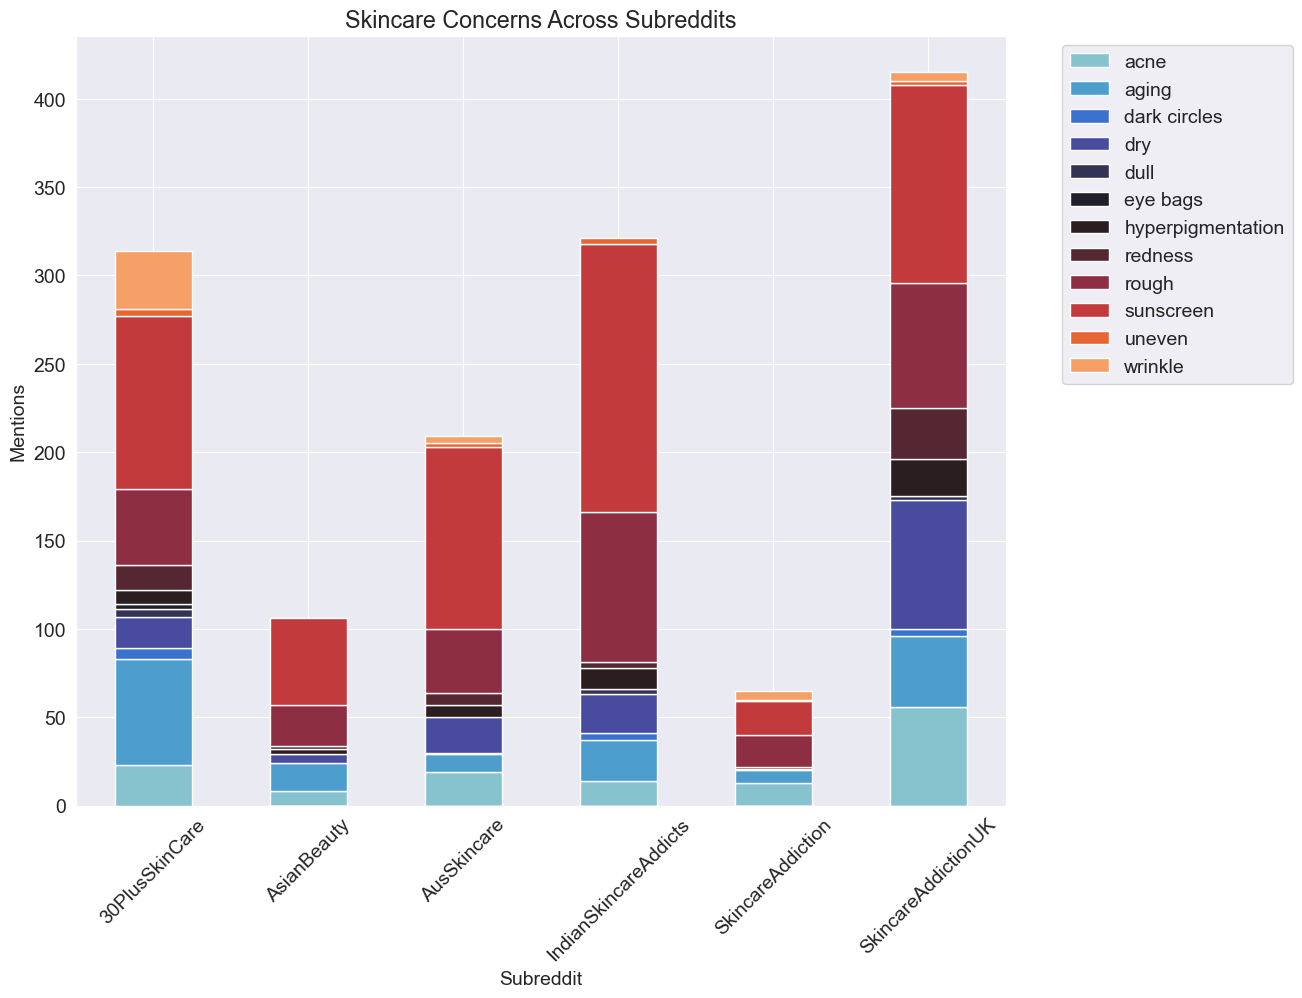

In [312]:
sub_concern = wdf.groupby(['subreddit', 'concern']).size().unstack(fill_value=0)
stacked_colour = sns.color_palette("icefire",12)
sub_concern.plot(kind='bar', stacked=True, figsize=(12, 10), title="Skincare Concerns Across Subreddits", color=stacked_colour)
plt.xticks(rotation=45)
plt.xlabel("Subreddit")
plt.ylabel("Mentions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('sub_concern.png') 
plt.show()

In line with the generalized bar plot, **sunscreen is the most important concern.** 

From this stacked plot, we see that 30 plus skincare mentions 'aging' more often than the other subreddits. It also has a large proportion of mentions towards sunscreen. Sun protection is considered one of the factors towards aging. Indian skincare and Aus skincare have large mentions of sunscreen, while UK skincare has the largest proportion of mentions of 'dry', these all match the skinare concerns associated with the climate of their respective countries. Indian skincare also has the largest proportion of 'rough' mentions. 

The stacked plot suggests that **there is a difference between skincare concerns between different demographics, and likely due to their different climates.**

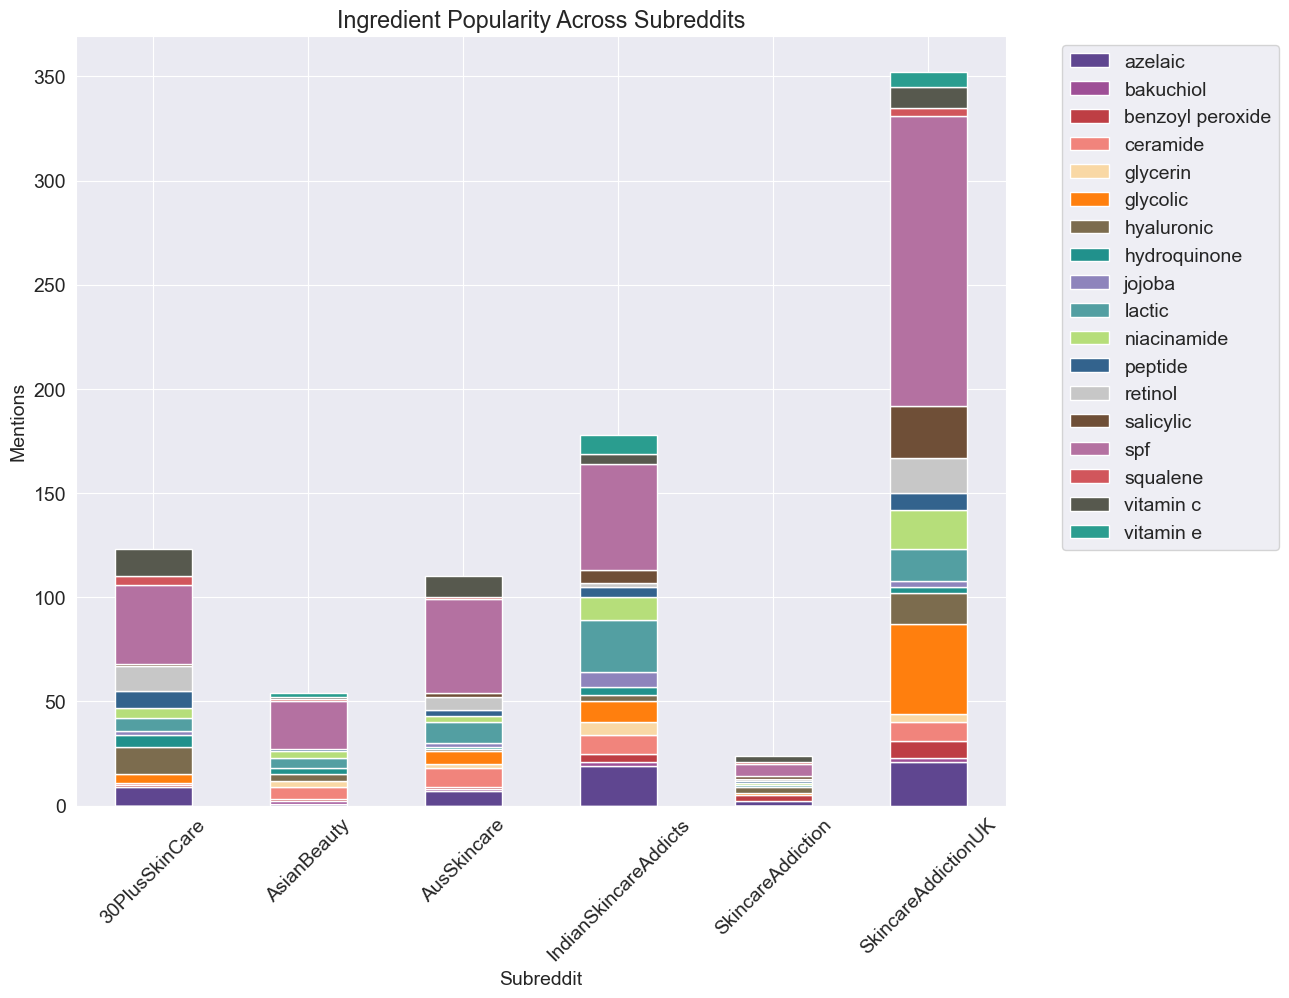

In [316]:
#same stacked plot for ingredients
sub_ing = wdf.groupby(['subreddit', 'ingredient']).size().unstack(fill_value=0)
many_colour = [
    '#5f4690', '#9e4f96', '#be3e44', '#f1847c', '#f9d8a5', 
    '#ff7f0e', '#7c6c4e', '#21918c', '#8e84bc', '#539fa2', 
    '#b6de7a', '#33638d', '#c7c7c7', '#6f4f37', '#b471a1', 
    '#d1565c', '#57594e', '#2a9d8f'
] #was not happy with anything I saw online so generated a custom palette
sub_ing.plot(kind='bar', stacked=True, figsize=(12, 10), title="Ingredient Popularity Across Subreddits", color=many_colour)
plt.xticks(rotation=45)
plt.xlabel("Subreddit")
plt.ylabel("Mentions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('sub_ing.png') 
plt.show()

Expectedly, **SPF if the most referenced ingredient in all 6 subreddits**, further signifying its importance within all skincare communities. 

Other than SPF, the UK subreddit, having the most posts, has a large distribution ingredients mentioned. The 30 plus sub reddit mentions benozyl peroxide,retinol and hydralauronic (acid) more often. While benozyl perioxide is a harsh active ingredient, retinol is associated with anti-aging and hydralauronic acid is hydrating - a property that grows in importance as skin matures. 

Lactic acid is mentioned to a larger degree in the Indian skincare subreddit. It is associated with exfoliation and improving skin texture, which matches up with the high proportion of 'rough' as a skin concern. Glycolic acid, another exfoliant, is more mentioned in the UK subreddit in contrast to other subreddits. The UK subreddit also had a high proportion of concern towards rough skin. It is interesting that despite both communities being concerned with rough skin, the choice of popular exfoliant differs. **It can be noted that even when trying to achieve similar results, different demographics would opt for different items based on both availabilities or side effects that are more relavant to their enviornment.**

#### 4.2 Changes in skincare trends over time
Within this we will also be looking at: 
- Have skincare trends moved differently between the different demographics?

First, a line graph will be plotted to see how the different ingredients have moved over time. I am also interestd to see how spf has moved over time, given its importance throughour the subreddit.

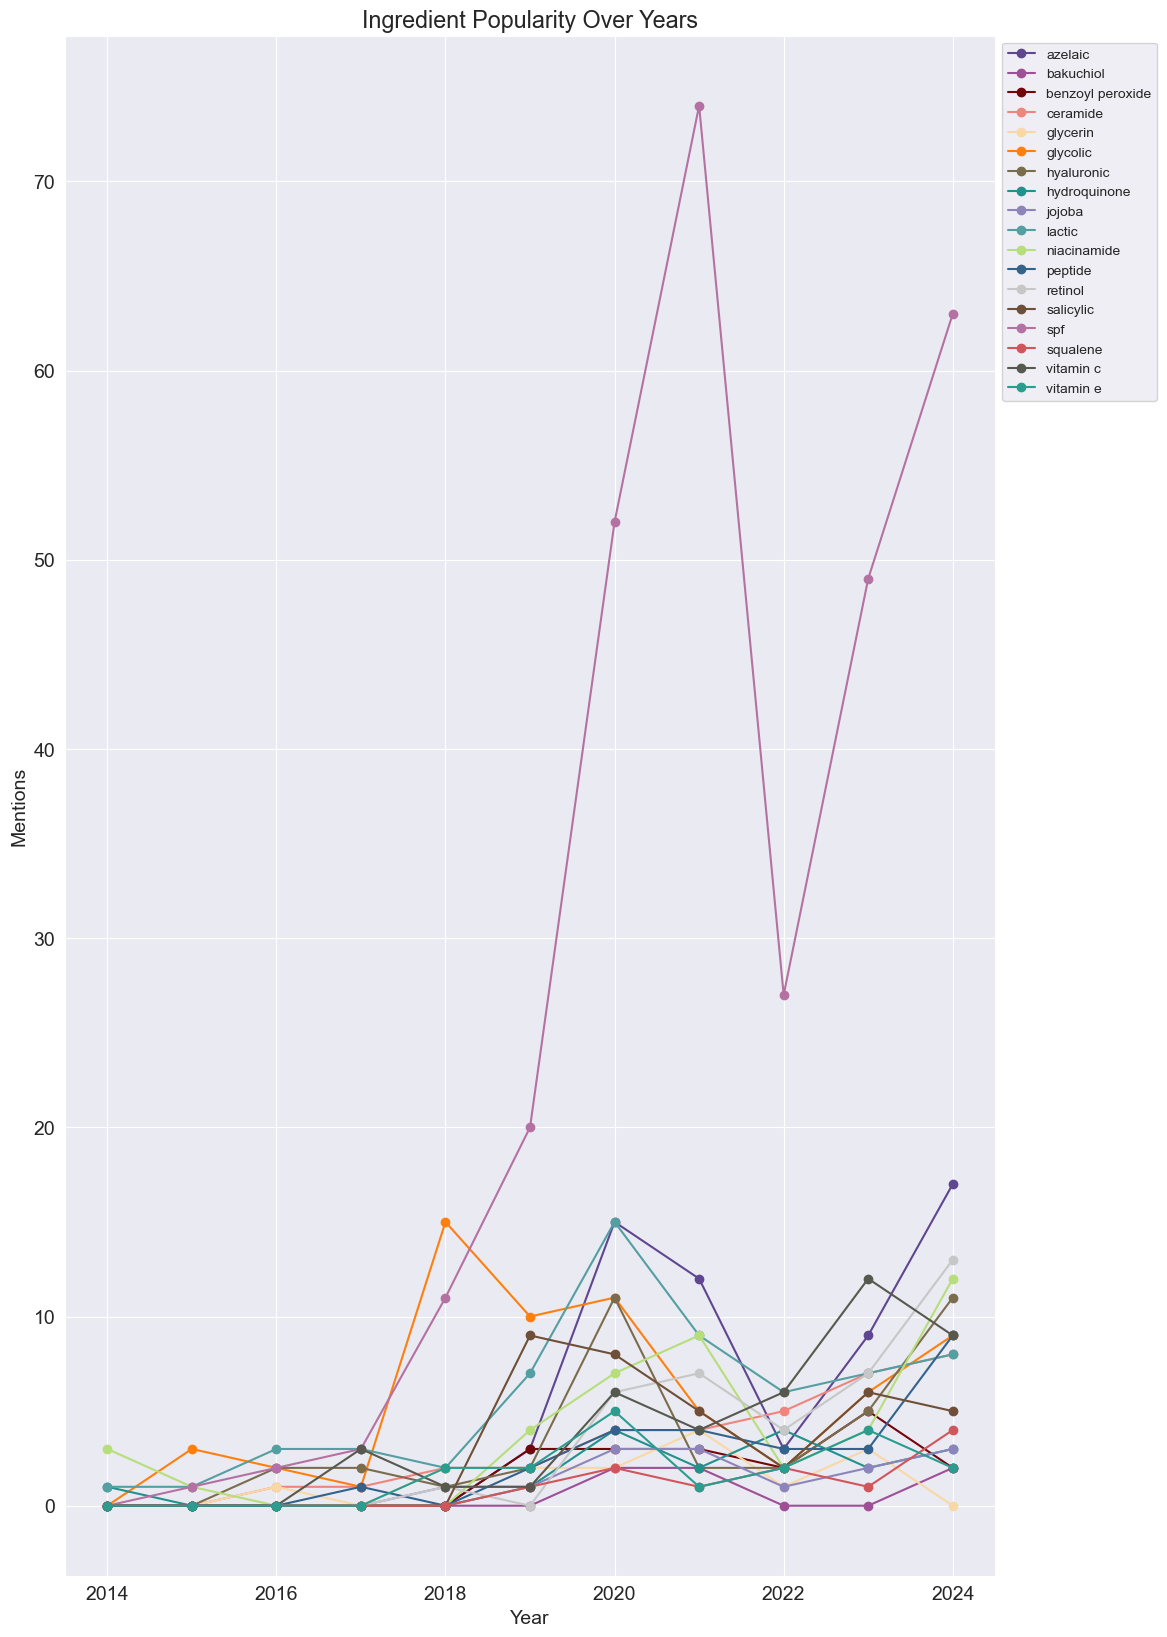

In [331]:
time_ing = wdf.groupby(['year', 'ingredient']).size().unstack(fill_value=0)
many_colour_darker = [
    '#5f4690', '#9e4f96', '#73060b', '#f1847c', '#f9d8a5', 
    '#ff7f0e', '#7c6c4e', '#21918c', '#8e84bc', '#539fa2', 
    '#b6de7a', '#33638d', '#c7c7c7', '#6f4f37', '#b471a1', 
    '#d1565c', '#57594e', '#2a9d8f'
] #some colours were too similar in the line graph so changed
 #lengthened the diagram since spf is so much more 'popular'
time_ing.plot(kind='line', figsize=(12, 20), title="Ingredient Popularity Over Years",marker='o',color=many_colour_darker)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10) 
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.savefig('time_ing.png')
plt.show() #73060b

From the line graph of the ingredients trend, we see most skincare ingredients were not as popular between 2014 to 2017, with glycolic acid popularlity spiking in 2018. It's popularity peaked there, decreased and is on the rise again in 2024. 

A similar trend is seen for hydroquinone, where its popularity spiked in 2020, decreased and is increasing again.  

Azelaic acid, the second most mentioned ingredient in this data set, had a spike in 2020, went down and has currently spiked again. 

Both peptides and retinol did not have a previous spike in popularity and are two ingredients that have been around but rose in popularity in 2023-2024. 

For hyralaunic acid, its popularity remained moderate, but has picked up in the last two years.

The most interesting skincare trend is the interest in spf. It was only moderately increasing between 2014-2016, while in 2017 it increased marginally and remained releveant until now, despite a dip in 2022. **This suggests that the 'holy grail' of skincare, which is spf, was not actually deemed as super important to the general skincare-loving comunity until 2017.** Additionally, the interest in spf also did not dip in 2020, when a large majority of people did not go out, but remained increasing. 

It should also be noted that while the line graph seems continous, it is using data per year. A more comprehensive understanding of the time-trends would encompass the months or days. 

**How have these trends fared within each demographic?** 

Based on the ingredients that have spiked in popularity over the past two years, we will be exploring the trends within each sub for: spf, glycolic, retinol, vitamin c, hydralaournic acid and niacinamide.

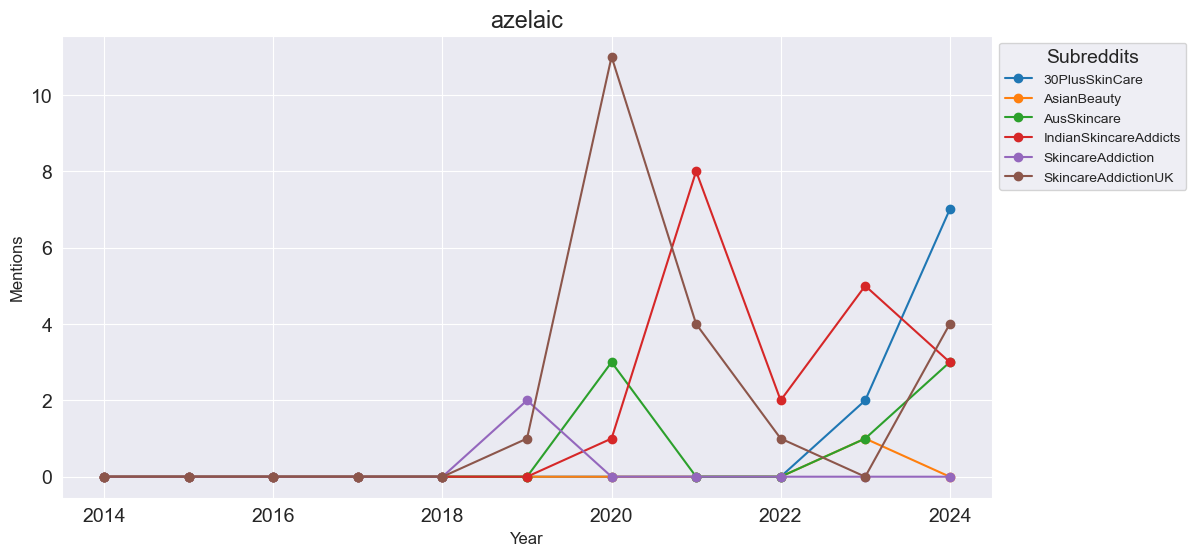

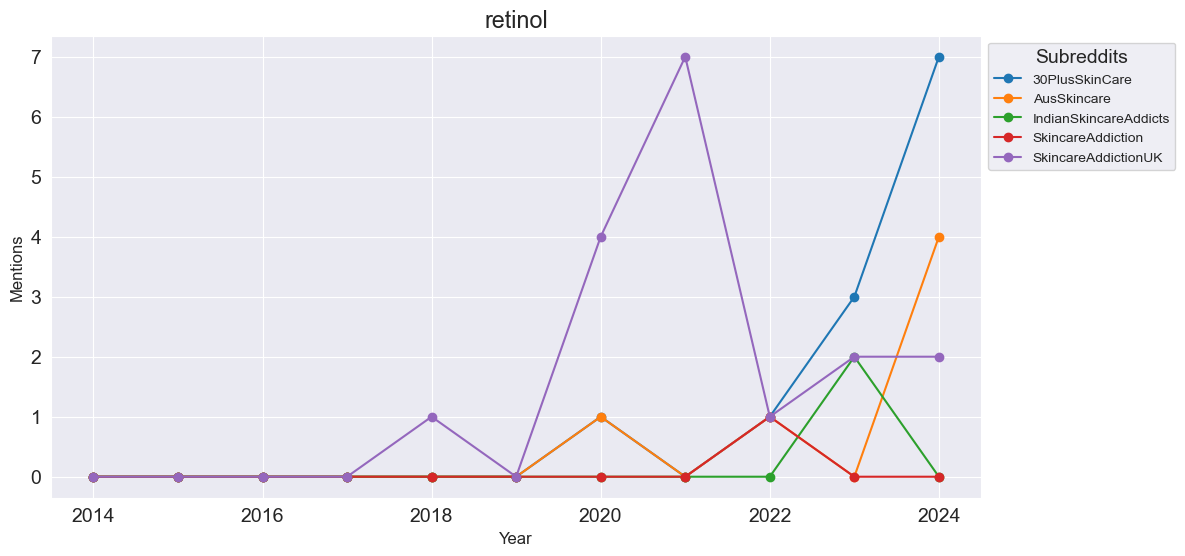

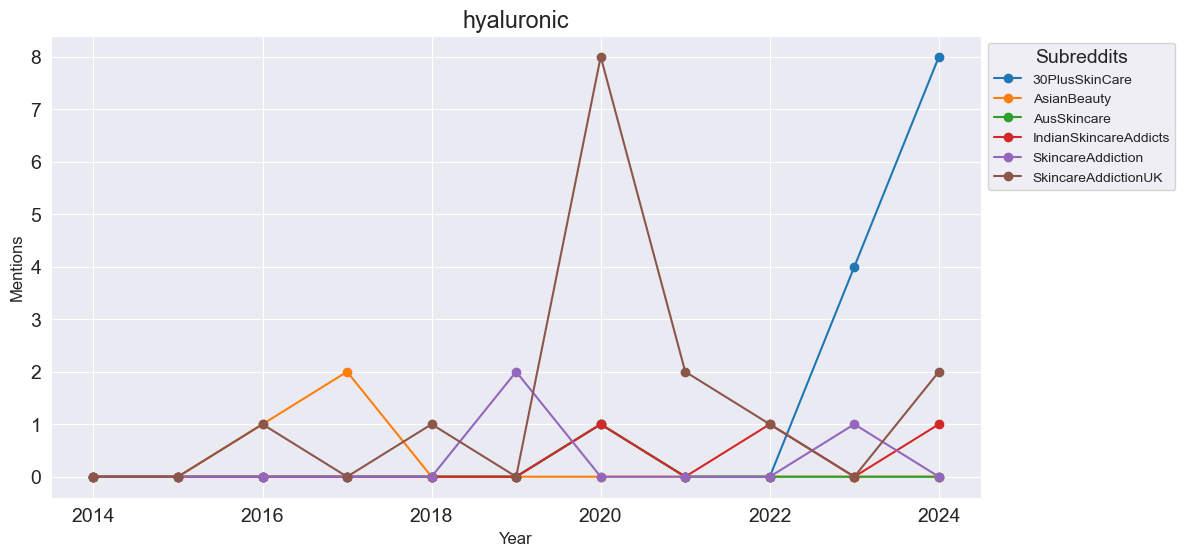

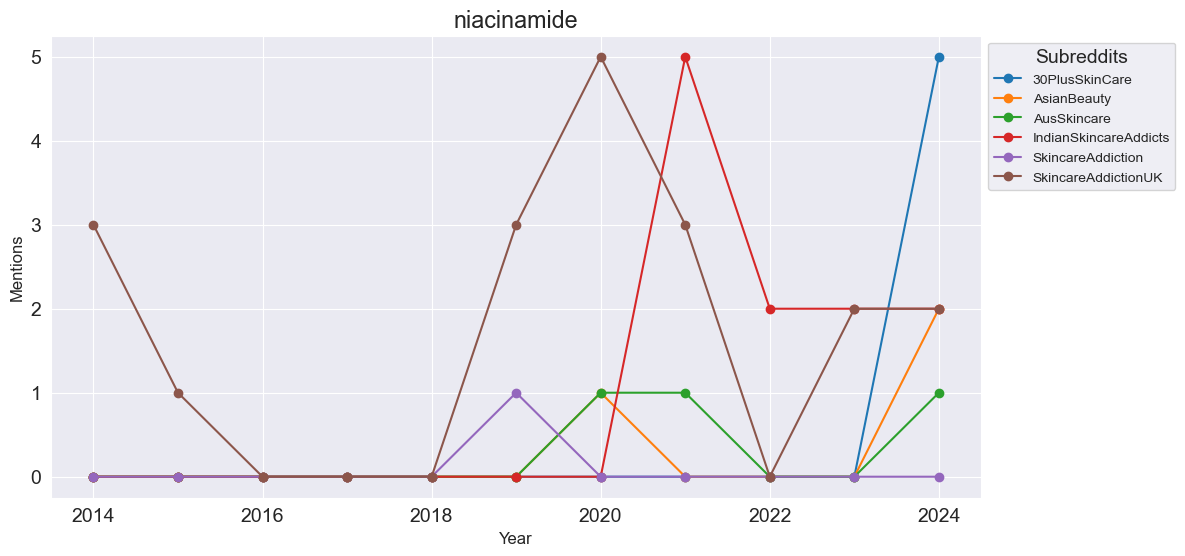

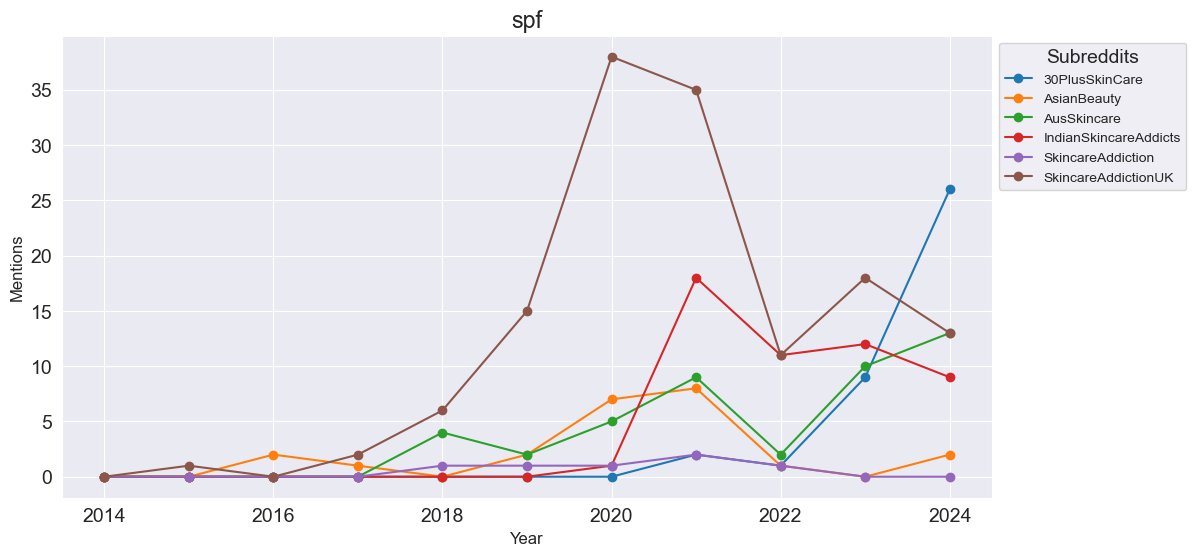

In [337]:
ing_interest = ['azelaic', 'retinol', 'hyaluronic', 'niacinamide','spf']
subreddit_groups = wdf.groupby(['year', 'subreddit', 'ingredient']).size().reset_index(name='mentions')
pivot_trend = subreddit_groups.pivot_table(
    index='year', 
    columns=['ingredient', 'subreddit'], 
    values='mentions', 
    fill_value=0
)
for ingredient in ing_interest:
    plt.figure(figsize=(12, 6))
    
    ing_interest = pivot_trend[ingredient]  
    
    for subreddit in ing_interest.columns:
        plt.plot(
            ing_interest.index,  # Years
            ing_interest[subreddit],  # Mentions
            marker='o',
            label=subreddit
        )
    
    plt.title(ingredient)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Mentions", fontsize=12)
    plt.legend(loc='upper left', title="Subreddits", bbox_to_anchor=(1, 1), fontsize=10)
    plt.grid(True)
    plt.savefig('ing_per_subs.png')
    plt.show()

- **Azelaic acid** has trended the most in the UK subreddit, it increased in popularity between 2019 and 2020, and dipped completely but has icnreased again this year. Other subreddits, like Indian Skincare, had the ingredient trend before but its popularity decreased. Meanwhile 30+ skincare and Aus skincare are seeing an increase in this ingredients popularity.

- For **retinol**, its popularity is picking up the most in 30+skincare, particularly in the last 2 years. UK Skincare had its peak in 2021. Meanwhile, retinol was not found in AsianBeauty, and within Indian skincare, has only a small pick up in interest and has gone down completely. It is possible strong ingredients such as retinol are not favoured in these communities.  

- As for **Hyaluronic acid**, each of the subreddits have seen an cyclical increase in the ingredient. However, UK skincare peaked in its favour for the ingredient in 2020, while 30+ skincare has just started getting interested in it. 

- **Niacinamine's** popularity has picked up and slowed down many times with all of the subreddits. 30+ skincare, UK Skincare and Indian Skincare in particular have seen very steep increases in its popularity. Its populaity is also slowly picking up in Aus Skincare and even Asian Beauty, which has not been following most of the trends.

- As for **SPF**, its popularity spiked the most within the UK subreddit in 2020, but all subreddits saw an increase in its popularity, including Asian skincare. But 30+ skincare is currently increasing in its interest while the other subreddits have stabilized. 

Given the small amount of data from SkincareAddiction, there were no visible trends from the subreddit. 

From the graphs, the data generated could be considered highly unrelaiable. The differences in trends could also be attributed to how active the subreddit is. For example, SkincareAddicts UK saw alot of dips and peaks in 2020, while 30+ Skincare is seeing many peaks now. **It is possible that this is more a reflection of the subreddits activity over the years rather than a reflection of the members interest in certain ingredients.**

#### After looking at the skincare trends, we are going to attempt a sentiment analysis to find out the redditors views on these skincare trends. 

In [342]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/nandika/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/nandika/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/nandika/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/nandika/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/nandika/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

True

In [344]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [346]:
#preprocessing data for analysis
def preprocessing(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [348]:
wdf['sentiment'] = wdf['body'].apply(preprocessing)
wdf

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year,members,upvotes_norm,comments_norm,engagement,sentiment
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,NaN,sunscreen,2020,4300000,252.651163,7.744186,0.030652,pepper spray : -don ’ touch exposed area ! spr...
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022,4300000,174.279070,10.116279,0.058046,post see incredibly concerning mental health s...
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,NaN,acne,2019,4300000,173.651163,6.837209,0.039373,"1. april 2. fool . wish thing existed know , '..."
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,NaN,acne,2019,4300000,168.558140,8.162791,0.048427,fuck acne fuck acne fuck fuck fuck fuck acne f...
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,NaN,redness,2023,4300000,166.279070,5.441860,0.032727,prescribed silvadene apply burn wound closed ....
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,vitamin c,rough,2021,177000,23.728814,8.474576,0.357143,"unpopular opinion know . 'm new skincare , go ..."
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,jojoba,NaN,2020,177000,24.293785,32.203390,1.325581,priceline another big 3 day sale ! brand inclu...
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,spf,NaN,2020,177000,23.163842,18.644068,0.804878,watched rihanna 's `` behind fenty skin '' vid...
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,bakuchiol,NaN,2020,177000,25.423729,11.864407,0.466667,"moo goo 's website , clicking around looking b..."


In [358]:
# initialize the sentiment analyzer
analyser = SentimentIntensityAnalyzer()
# create get_sentiment function
def get_sentiment(text):
    scores = analyser.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# apply get_sentiment function
wdf['sentiment_val'] = wdf['sentiment'].apply(get_sentiment)
wdf

,subreddit,title,body,upvotes,num_comments,ingredient,concern,year,members,upvotes_norm,comments_norm,engagement,sentiment,sentiment_val
6,SkincareAddiction,[PSA] SKIN CARE FOR PROTESTERS,\nFOR PEPPER SPRAY: \n\n-Don’t touch the expos...,10864,333,NaN,sunscreen,2020,4300000,252.651163,7.744186,0.030652,pepper spray : -don ’ touch exposed area ! spr...,1
28,SkincareAddiction,"[Misc] Some of you need a therapist, not a der...",Some of the posts I see on here are incredibly...,7494,435,retinol,aging,2022,4300000,174.279070,10.116279,0.058046,post see incredibly concerning mental health s...,1
30,SkincareAddiction,[Acne] My acne and sebaceous filaments have al...,1. APRIL\n2. Fools.\n\nI wish such a thing exi...,7467,294,NaN,acne,2019,4300000,173.651163,6.837209,0.039373,"1. april 2. fool . wish thing existed know , '...",1
33,SkincareAddiction,[Acne] Fuck acne fuck acne fuck acne fuck acne...,Fuck acne fuck acne fuck fuck fuck fuck acne f...,7248,351,NaN,acne,2019,4300000,168.558140,8.162791,0.048427,fuck acne fuck acne fuck fuck fuck fuck acne f...,0
34,SkincareAddiction,[Before&After] Faceplanted in a fire pit about...,Was prescribed Silvadene to apply in the burns...,7150,234,NaN,redness,2023,4300000,166.279070,5.441860,0.032727,prescribed silvadene apply burn wound closed ....,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,AusSkincare,Whats the point of having actives in cleansers...,Unpopular opinion i know. I'm not new to skinc...,42,15,vitamin c,rough,2021,177000,23.728814,8.474576,0.357143,"unpopular opinion know . 'm new skincare , go ...",1
2197,AusSkincare,"Priceline 3 Day Sale (40% off Skincare, Suncar...",Priceline is doing another big 3 day sale! \n\...,43,57,jojoba,NaN,2020,177000,24.293785,32.203390,1.325581,priceline another big 3 day sale ! brand inclu...,1
2198,AusSkincare,Fenty Skin!,"I just watched Rihanna's ""Behind Fenty Skin"" v...",41,33,spf,NaN,2020,177000,23.163842,18.644068,0.804878,watched rihanna 's `` behind fenty skin '' vid...,1
2199,AusSkincare,PSA: Moo Goo has launched a 1% bakuchiol serum!,"So I was on Moo Goo's website, clicking around...",45,21,bakuchiol,NaN,2020,177000,25.423729,11.864407,0.466667,"moo goo 's website , clicking around looking b...",1


In [362]:
wdf['sentiment_val'].value_counts()

sentiment_val
1    1591
0      84
Name: count, dtype: int64

#### Displaying the values 

After generating the values, which, through the method imported, is either a 0 or 1, with 1 being positive. It will be displayed with a simple bar chart for concerns and ingredients.

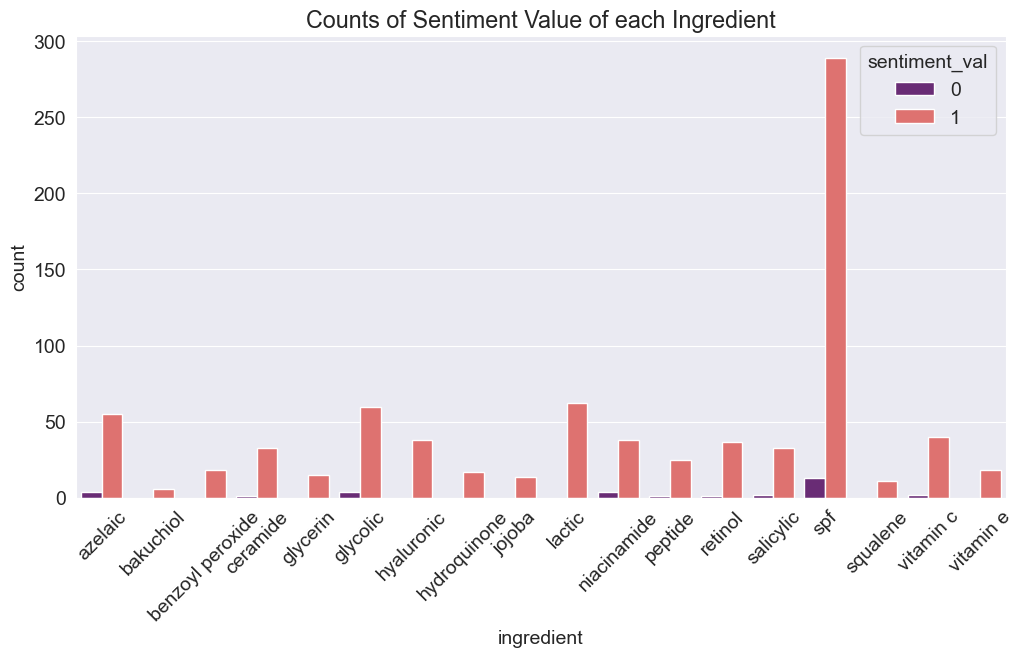

In [367]:
plt.figure(figsize=(12, 6))
ing_sent = wdf.groupby(['ingredient', 'sentiment_val']).size().reset_index(name='count')
lala = sns.color_palette("magma",2)
sns.barplot(x='ingredient', y='count', hue='sentiment_val', data=ing_sent, palette=lala) 
plt.title("Counts of Sentiment Value of each Ingredient")
plt.xticks(rotation=45)
plt.savefig('ing_sent.png')
plt.show()

Most ingredients have positive sentiments towards them, with the exception of azelaic, benzoyl peroxide, glycolic, niacinamide, peptie, retinol, salyclic and vitamin c. SPF, being the most referenced, also has the most negative sentiment. Most of these are more active ingredients which could possibly mean more potential adverse effects. 

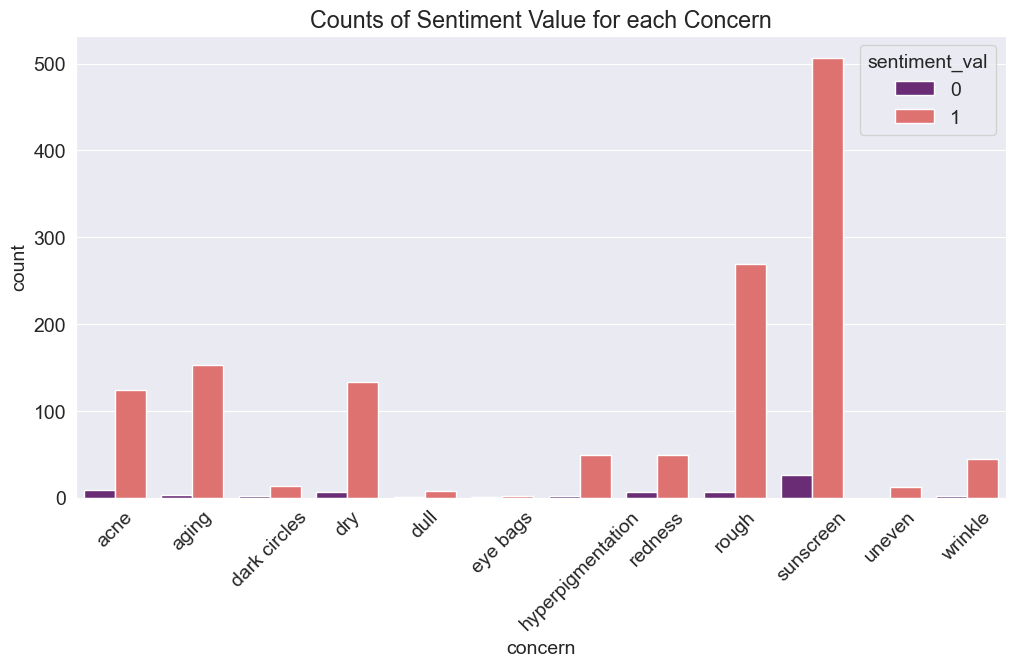

In [374]:
plt.figure(figsize=(12, 6))
conc_sent = wdf.groupby(['concern', 'sentiment_val']).size().reset_index(name='count')  # Make sure 'concern' exists
lala = sns.color_palette("magma", 2)
sns.barplot(x='concern', y='count', hue='sentiment_val', data=conc_sent, palette=lala)  # Use the correct DataFrame
plt.title("Counts of Sentiment Value for each Concern")
plt.xticks(rotation=45)
plt.savefig('conc_sent.png')
plt.show()

Suprisingly, there is not as many negative sentiments towards skincare concerns, even though they are concerns. 

Sentiment analysis unfortunately did not give insight into perceptions of skincare ingredients. 

#### Final analysis: relationship between concerns and ingredients

As an additional step, we want to see if there is strong associations between skincare concerns and ingredients. This will use the df_both dataframe that was created and cleaned earlier. 

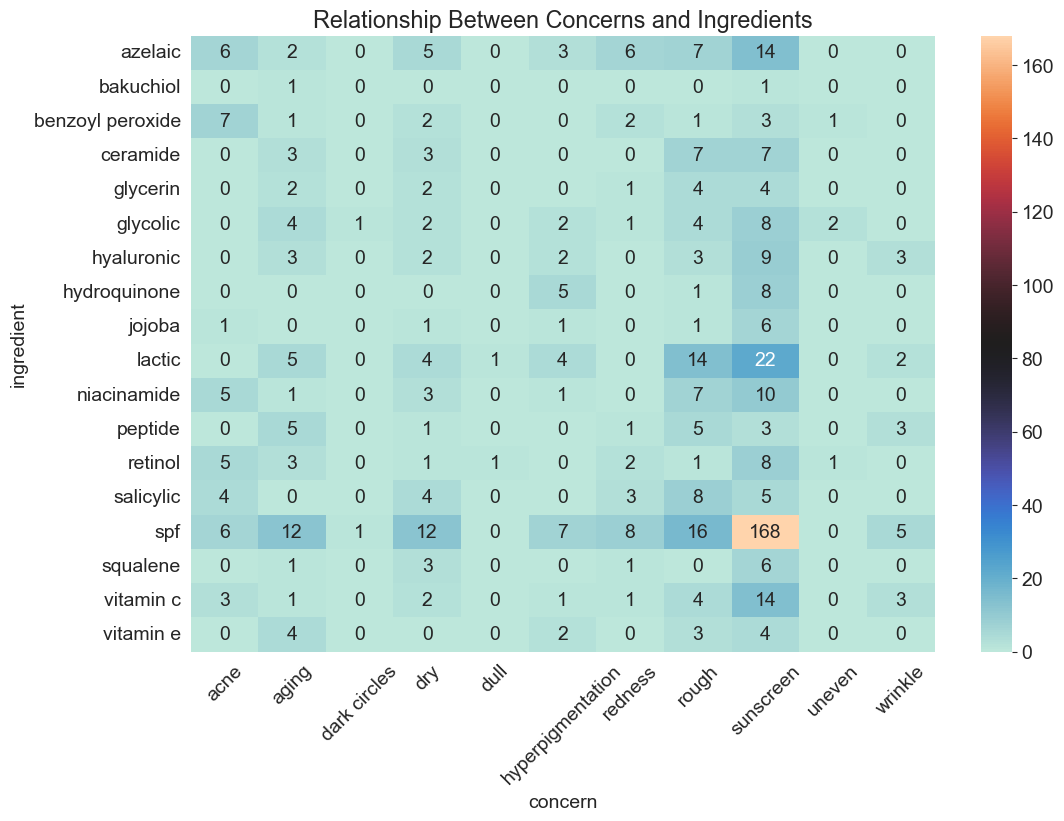

In [388]:
ing_con = pd.crosstab(df_both['ingredient'],df['concern'])
plt.figure(figsize=(12, 8))
pretty = sns.color_palette("icefire", as_cmap=True)
sns.heatmap(ing_con, annot=True, fmt='d', cmap=pretty) 
plt.xticks(rotation=45)
plt.title('Relationship Between Concerns and Ingredients')
plt.savefig('association_heatmap.png')
plt.show()

The heatmap showcases that there is not much relationship between specific ingredients and concerns within this dataset. 

The presence of spf and sunscreen skews this dataset by a significant margin. However, both sunscreen and spf are associated with other factors. Hence, >10 will be used as a consideration for association, 

SPF is related to other skincare concerns such as aging, dry and rough skin while sunscreen is associated with 4 other ingredients. However since sunscreen was used as a proxy for finding out if posters were concerned about sun protection/sun damage, this is likely more related to sunscreen formulations. 

Notably, Lactic acid and rough have a strong corrolation of 14, this is in line with the igngredient being an exfoliant. The end goal of using it would be to smoothen skin. 

### Conclusion

At the begining, we asked: **How has skincare trends changed over the last few years?**

From the exploratory analysis, the *most significant change over the last 10 years within skincare trends is an interest in sun protection.* With all other ingredients, they have risen and fallen in popularity, and it differs between subreddits and demographics. For the sub questions of demographic differences, we do see differences skin concerns and preference towards ingredients, however not with the expected intensity. 30+ skincare did show som expected trends with ingredients, such as retinol.

Additionally, there are some **limitations and considerations** to this analysis:

Firstly, The data set itself could be more a reflection on the subreddits popularity than the ingredients poopularity itself.

The two biggest subreddits had too little data to generalize any trends, which brought into question the usefulness of these two subreddits for the purposes of gettng skincare advice. Conversely from this, the 3rd largest subreddit, 30+Skincare, had many data points to pull from, and many of the results was according to what was expected. 

It should be acknowldged that further refinement of the data extraction procss would provide better results to this analysis. Sunscreen and spf, while they provided the strongest results, made looking into other ingredients more difficult.  

One consideration was to scrape each reddit to find the number of times an ingredient was mentioned in both title, body and comments. However, this process took 20 minutes per ingredient when it was tested. Hence in the interest of time and memory, it was not used. 


#### Further Analysis

Further analysis could include specific product mentions as well as statistical analysis that could be used in a predictive analysis to decide what kind of trends are likely to be seen the next year. 